## Autify: Automatic Playlist Continuation for Spotify

### Import necessary libraries

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix
from implicit.gpu.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/srv/homes/ipanagou/miniconda3/envs/autify/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load datasets

In [2]:
# groundtruth contains all the playlist_id interactions
groundtruth = pd.read_csv('./data/million_playlist_dataset/playlists_tracks.csv')
# for each entry add a column with a value of 1 (indicating that there is an interaction)
groundtruth['val'] = 1.0
# normalize val by the count of songs in each playlist
groundtruth['val_normalized'] = groundtruth.groupby('playlist_id').val.transform(lambda x: x / np.linalg.norm(x))
# add the popularity of each song (how many it appears in total in the dataset)
groundtruth = groundtruth.join(groundtruth.track_id.value_counts().rename('popularity'), on = 'track_id')
groundtruth.head(n = 10)

,playlist_id,track_id,artist_id,pos,val,val_normalized,popularity
0,101000,0,1,0,1.0,0.107833,1400
1,101000,1,2,1,1.0,0.107833,343
2,101000,2,3,2,1.0,0.107833,164
3,101000,3,4,3,1.0,0.107833,2376
4,101000,4,5,4,1.0,0.107833,8595
5,101000,5,6,5,1.0,0.107833,1167
6,101000,6,7,6,1.0,0.107833,1411
7,101000,7,8,7,1.0,0.107833,860
8,101000,8,3,8,1.0,0.107833,76
9,101000,9,9,9,1.0,0.107833,4523


In [3]:
tracks = pd.read_csv('./data/million_playlist_dataset/tracks.csv')
tracks.head(n = 10)

,track_id,track_uri,track_name,artist_id,album_uri,duration_ms,album_name,acousticness,danceability,energy,instrumentalness,mode,loudness,speechiness,tempo,time_signature,valence
0,0,spotify:track:4NaPX1b3NsQqJrrAwkkvVc,The Mixed Tape - 2015 Remastered,1,spotify:album:7gfFEfHxjkmy6sP1fhLaJM,194440,Everything In Transit,0.568000,0.458,0.591,0.000015,1.0,-5.621,0.0326,184.913,3.0,0.6540
1,1,spotify:track:3oorif6IxWNSNSGNPE7Oi8,City,2,spotify:album:5UDclAH0fCsoxelbtsoT0y,235072,ADHDS,0.797000,0.455,0.623,0.903000,1.0,-11.572,0.0523,182.345,4.0,0.9510
2,2,spotify:track:70E2GMpGxqyuLbFi2yh1Dv,2faded,3,spotify:album:5KqinqqigtIgPbuxVB34zA,245973,Faded - EP,0.017800,0.742,0.753,0.000000,1.0,-5.632,0.0364,132.064,4.0,0.2630
3,3,spotify:track:06b3VaFsqYqbvQj1zFV5KM,Drive,4,spotify:album:7IbXPN9iNFIBMutzPj6NaZ,187915,This Is What It’s Like,0.086000,0.733,0.711,0.000000,1.0,-5.408,0.1580,138.076,4.0,0.3460
4,4,spotify:track:3e0yTP5trHBBVvV32jwXqF,Anna Sun,5,spotify:album:1QhonXpNQq8wrGEKX0ofbk,321280,Walk The Moon,0.014500,0.584,0.947,0.000039,1.0,-3.702,0.0748,100.874,4.0,0.4600
5,5,spotify:track:7j5DNclXXrNL4LPw59qcUK,End Credits,6,spotify:album:5bbk7Mo2OiD6q5Bb52DIkC,240389,End Credits,0.799000,0.507,0.446,0.000000,0.0,-6.141,0.0276,133.158,4.0,0.4180
6,6,spotify:track:3a2MbZSw3NGRWHqsCJ4iQj,I Was Wrong,7,spotify:album:2FNk380jCQyICbwtkOdEHE,217293,GALLERY,0.883000,0.253,0.197,0.005620,1.0,-17.695,0.0461,61.556,4.0,0.3770
7,7,spotify:track:0ytCr0BRergKfjMYayYycg,Shine A Light,8,spotify:album:2ztnrpo6EzarVTkkRk3EcD,225120,Shine A Light,0.795000,0.295,0.498,0.944000,0.0,-9.190,0.0301,89.048,3.0,0.0445
8,8,spotify:track:4WYIDSi83k64BH3k5DmKl9,Lost In The Wild,3,spotify:album:12NHVD38cSO5IuLzEr5yma,282882,Lost In The Wild,0.164000,0.648,0.598,0.000046,1.0,-11.845,0.3260,138.883,4.0,0.4000
9,9,spotify:track:5EQ9yEra0SzVd673ZfKT4C,Brand New,9,spotify:album:4E2YvGzYMgr4DizJJ0PQoo,243933,Brand New,0.000007,0.695,0.828,0.851000,1.0,-6.818,0.0457,126.014,4.0,0.0372


In [4]:
playlists = pd.read_csv('./data/million_playlist_dataset/playlists.csv')
playlists.head(n = 10)

,playlist_id,name,num_tracks,num_artists,num_albums,num_followers,num_edits,duration_ms,modified_at,collaborative,description
0,101000,bands,86,66,73,1,15,18966630,1490659200,False,NaN
1,101001,Chill,31,17,23,1,14,7176914,1495238400,False,NaN
2,101002,hip hop/rap,53,34,46,3,4,12199191,1434067200,False,NaN
3,101003,melT,29,15,23,1,6,3260443,1509235200,False,NaN
4,101004,Bangers,17,13,16,1,14,4073917,1497571200,False,NaN
5,101005,Tvd,13,12,12,1,6,3520732,1489104000,False,NaN
6,101006,Best of 2014,33,31,31,1,2,7955493,1450137600,False,NaN
7,101007,Baby Shower,20,15,19,1,4,4668169,1506729600,False,NaN
8,101008,Throwback,234,122,189,3,3,55438417,1500336000,False,NaN
9,101009,mmm,7,4,4,1,4,4075424,1465948800,False,NaN


### Explore Datasets

In [5]:
num_playlists = np.unique(groundtruth['playlist_id']).shape[0]
num_tracks = np.unique(groundtruth['track_id']).shape[0]

print(f'The dataset contains {num_playlists} playlists with a total of {num_tracks} tracks')

The dataset contains 1000000 playlists with a total of 2262292 tracks


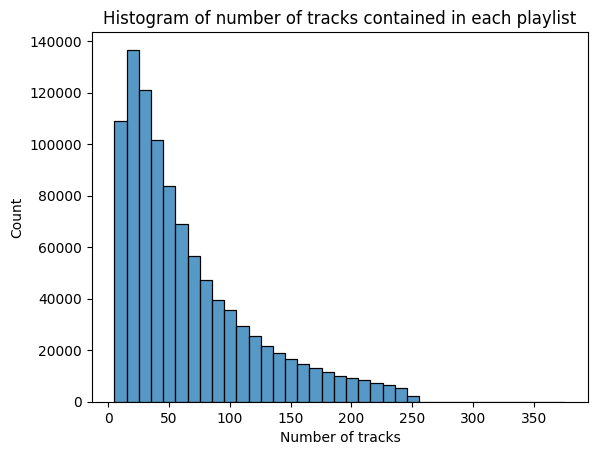

In [6]:
g = sns.histplot(data = playlists, x = 'num_tracks', binwidth=10)
g.set_title('Histogram of number of tracks contained in each playlist');
g.set_xlabel('Number of tracks');

### Split into train, val and test dataset

In [7]:
groundtruth = groundtruth.sort_values(by = 'playlist_id')
ids = np.unique(groundtruth['playlist_id'])
train_ids, val_ids = train_test_split(ids, test_size = 0.2, shuffle = False)
val_ids, test_ids = train_test_split(val_ids, test_size = 0.5, shuffle = False)

train_df = groundtruth[groundtruth['playlist_id'].isin(train_ids)]
val_df = groundtruth[groundtruth['playlist_id'].isin(val_ids)]
test_df = groundtruth[groundtruth['playlist_id'].isin(test_ids)]

In [8]:
num_train_playlists = np.unique(train_df['playlist_id']).shape[0]
num_val_playlists = np.unique(val_df['playlist_id']).shape[0]
num_test_playlists = np.unique(test_df['playlist_id']).shape[0]

print(f'Number of playlists in training dataset: {num_train_playlists}')
print(f'Number of playlists in validation dataset: {num_val_playlists}')
print(f'Number of playlists in testing dataset: {num_test_playlists}')

Number of playlists in training dataset: 800000
Number of playlists in validation dataset: 100000
Number of playlists in testing dataset: 100000


In [9]:
# keep only the playlists with more than 25 songs in validation and testing set
mask = groundtruth['playlist_id'].isin(val_ids)
val_ids = np.unique(groundtruth[mask].groupby('playlist_id').filter(lambda x: x['track_id'].count() > 25 )['playlist_id'].to_numpy())

mask = groundtruth['playlist_id'].isin(test_ids)
test_ids = np.unique(groundtruth[mask].groupby('playlist_id').filter(lambda x: x['track_id'].count() > 25 )['playlist_id'].to_numpy())

train_df = groundtruth[groundtruth['playlist_id'].isin(train_ids)]
val_df = groundtruth[groundtruth['playlist_id'].isin(val_ids)]
test_df = groundtruth[groundtruth['playlist_id'].isin(test_ids)]

In [10]:
print('Number of playlists in training dataset: {}'.format(np.unique(train_df['playlist_id']).shape[0]))
print('Number of playlists in validation dataset: {}'.format(np.unique(val_df['playlist_id']).shape[0]))
print('Number of playlists in testing dataset: {}'.format(np.unique(test_df['playlist_id']).shape[0]))

Number of playlists in training dataset: 800000
Number of playlists in validation dataset: 75549
Number of playlists in testing dataset: 75313


In [11]:
groundtruth[mask].groupby('playlist_id').apply(lambda group: group.head(25)).reset_index(drop = True)

,playlist_id,track_id,artist_id,pos,val,val_normalized,popularity
0,900000,6440,74,1,1.0,0.166667,5019
1,900000,4844,1309,21,1.0,0.166667,14444
2,900000,10238,101,22,1.0,0.166667,14881
3,900000,4880,1048,23,1.0,0.166667,23633
4,900000,6460,1038,24,1.0,0.166667,12919
...,...,...,...,...,...,...,...
2283382,999999,618235,3615,79,1.0,0.095346,22
2283383,999999,260004,3867,57,1.0,0.095346,154
2283384,999999,162212,3865,56,1.0,0.095346,65
2283385,999999,227938,3865,67,1.0,0.095346,33


In [12]:
# Simulate missing entries in validation and testing dataset (keep only the 25 first tracks)
mask = groundtruth['playlist_id'].isin(train_ids)
train_df = groundtruth[mask]

mask = groundtruth['playlist_id'].isin(val_ids)
val_df = groundtruth[mask].groupby('playlist_id').apply(lambda group: group.head(25)).reset_index(drop = True)

mask = groundtruth['playlist_id'].isin(test_ids)
test_df = groundtruth[mask].groupby('playlist_id').apply(lambda group: group.head(25)).reset_index(drop = True)

In [13]:
df = pd.concat([train_df, val_df, test_df], axis = 0)

### Alternating Least Squares (ALS) for Matrix Factorization

In [14]:
# create sparse matrix from playlist and tracks
playlist_tracks = csr_matrix((df['val'], (df['playlist_id'].astype(int), df['track_id'].astype(int))), shape = (num_playlists, num_tracks))

#### Hyperparameter tuning (training)

In [15]:
# grid search using the validation dataset
ids = np.unique(val_ids).tolist()

best_r_precision_als = -np.Inf
best_params_als = {}

factors = [50, 100, 150, 200, 500]
regularization = [0, 0.1, 1, 10, 100, 500]
alpha = [1, 10, 20, 40, 100]

results = {}
results['factors'] = []
results['regularization'] = []
results['alpha'] = []
results['r_precision'] = []

for f in factors:
    for r in regularization:
        for a in alpha:
            print(f'Training for factors = {f}, regularization = {r} and alpha = {a}')
            model = AlternatingLeastSquares(factors = f, regularization = r, alpha = a)
            model.fit(playlist_tracks)

            # compute r precision
            r_precision = 0.0

            # get 500 predictions (that are not already in the playlist)
            predicted_relevant_ids, scores = model.recommend(ids, playlist_tracks[ids], N = 500)
            
            # get the groundtruth values for those playlist ids 
            groundtruth_tracks = groundtruth[groundtruth['playlist_id'].isin(ids)]
            groundtruth_tracks = groundtruth_tracks.groupby('playlist_id')['track_id'].agg(list).reset_index()['track_id'].tolist()
            groundtruth_sets = [set(groundtruth_tracks[pid]) for pid in range(len(groundtruth_tracks))]

            # divide the number of num_correct by the number of the ones missing
            num_to_predict = np.array(groundtruth[groundtruth['playlist_id'].isin(ids)].groupby('playlist_id').count()['track_id'].tolist()) - 25
            
            # transform them into a list of sets
            predicted_relevant_ids_sets = [set(predicted_relevant_ids[pid, :num_to_predict[pid]]) for pid in range(predicted_relevant_ids.shape[0])]
            
            # get the number of common tracks in predicted and groundtruth sets
            num_correct = [len(groundtruth_sets[i] & predicted_relevant_ids_sets[i]) for i in range(len(predicted_relevant_ids))]
            r_precision = np.sum(num_correct / num_to_predict) / len(ids)

            print(f'R_precision for factors = {f}, regularization = {r} and alpha = {a}: {r_precision}')
            
            if r_precision > best_r_precision_als:
                best_params_als['factors'] = f
                best_params_als['regularization'] = r
                best_params_als['alpha'] = a
                best_r_precision_als = r_precision
            
            results['factors'].append(f)
            results['regularization'].append(r)
            results['alpha'].append(a)
            results['r_precision'].append(r_precision)
            
            del model

Training for factors = 50, regularization = 0 and alpha = 1


100%|██████████| 15/15 [00:01<00:00,  7.63it/s]


R_precision for factors = 50, regularization = 0 and alpha = 1: 0.11814887574650325
Training for factors = 50, regularization = 0 and alpha = 10


100%|██████████| 15/15 [00:01<00:00,  7.72it/s]


R_precision for factors = 50, regularization = 0 and alpha = 10: 0.11792508665121983
Training for factors = 50, regularization = 0 and alpha = 20


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 0 and alpha = 20: 0.11853194107852673
Training for factors = 50, regularization = 0 and alpha = 40


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 0 and alpha = 40: 0.11936228329541479
Training for factors = 50, regularization = 0 and alpha = 100


100%|██████████| 15/15 [00:01<00:00,  7.72it/s]


R_precision for factors = 50, regularization = 0 and alpha = 100: 0.11818703347693324
Training for factors = 50, regularization = 0.1 and alpha = 1


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 0.1 and alpha = 1: 0.11951899383678173
Training for factors = 50, regularization = 0.1 and alpha = 10


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 0.1 and alpha = 10: 0.11842315381092859
Training for factors = 50, regularization = 0.1 and alpha = 20


100%|██████████| 15/15 [00:01<00:00,  7.72it/s]


R_precision for factors = 50, regularization = 0.1 and alpha = 20: 0.1184816625931729
Training for factors = 50, regularization = 0.1 and alpha = 40


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 0.1 and alpha = 40: 0.1183322469376061
Training for factors = 50, regularization = 0.1 and alpha = 100


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 0.1 and alpha = 100: 0.118221349333241
Training for factors = 50, regularization = 1 and alpha = 1


100%|██████████| 15/15 [00:01<00:00,  7.72it/s]


R_precision for factors = 50, regularization = 1 and alpha = 1: 0.1191040101438039
Training for factors = 50, regularization = 1 and alpha = 10


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 1 and alpha = 10: 0.11886605793672357
Training for factors = 50, regularization = 1 and alpha = 20


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 1 and alpha = 20: 0.11906160761717803
Training for factors = 50, regularization = 1 and alpha = 40


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 1 and alpha = 40: 0.11949881605755405
Training for factors = 50, regularization = 1 and alpha = 100


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


R_precision for factors = 50, regularization = 1 and alpha = 100: 0.11880727680741532
Training for factors = 50, regularization = 10 and alpha = 1


100%|██████████| 15/15 [00:01<00:00,  7.69it/s]


R_precision for factors = 50, regularization = 10 and alpha = 1: 0.1186627552788645
Training for factors = 50, regularization = 10 and alpha = 10


100%|██████████| 15/15 [00:01<00:00,  7.70it/s]


R_precision for factors = 50, regularization = 10 and alpha = 10: 0.11882113379608146
Training for factors = 50, regularization = 10 and alpha = 20


100%|██████████| 15/15 [00:01<00:00,  7.69it/s]


R_precision for factors = 50, regularization = 10 and alpha = 20: 0.11930285967329846
Training for factors = 50, regularization = 10 and alpha = 40


100%|██████████| 15/15 [00:01<00:00,  7.70it/s]


R_precision for factors = 50, regularization = 10 and alpha = 40: 0.11865476283951185
Training for factors = 50, regularization = 10 and alpha = 100


100%|██████████| 15/15 [00:01<00:00,  7.70it/s]


R_precision for factors = 50, regularization = 10 and alpha = 100: 0.11888508743249682
Training for factors = 50, regularization = 100 and alpha = 1


100%|██████████| 15/15 [00:01<00:00,  7.69it/s]


R_precision for factors = 50, regularization = 100 and alpha = 1: 0.11902286077821854
Training for factors = 50, regularization = 100 and alpha = 10


100%|██████████| 15/15 [00:01<00:00,  7.70it/s]


R_precision for factors = 50, regularization = 100 and alpha = 10: 0.11864007045401524
Training for factors = 50, regularization = 100 and alpha = 20


100%|██████████| 15/15 [00:01<00:00,  7.69it/s]


R_precision for factors = 50, regularization = 100 and alpha = 20: 0.11923553290376201
Training for factors = 50, regularization = 100 and alpha = 40


100%|██████████| 15/15 [00:01<00:00,  7.70it/s]


R_precision for factors = 50, regularization = 100 and alpha = 40: 0.11931842567768584
Training for factors = 50, regularization = 100 and alpha = 100


100%|██████████| 15/15 [00:01<00:00,  7.69it/s]


R_precision for factors = 50, regularization = 100 and alpha = 100: 0.11958652635940178
Training for factors = 50, regularization = 500 and alpha = 1


100%|██████████| 15/15 [00:01<00:00,  7.97it/s]


R_precision for factors = 50, regularization = 500 and alpha = 1: 0.035012806204749405
Training for factors = 50, regularization = 500 and alpha = 10


100%|██████████| 15/15 [00:01<00:00,  7.90it/s]


R_precision for factors = 50, regularization = 500 and alpha = 10: 0.035194843743685
Training for factors = 50, regularization = 500 and alpha = 20


100%|██████████| 15/15 [00:01<00:00,  7.90it/s]


R_precision for factors = 50, regularization = 500 and alpha = 20: 0.035012806204749405
Training for factors = 50, regularization = 500 and alpha = 40


100%|██████████| 15/15 [00:01<00:00,  7.96it/s]


R_precision for factors = 50, regularization = 500 and alpha = 40: 0.034905542950188835
Training for factors = 50, regularization = 500 and alpha = 100


100%|██████████| 15/15 [00:01<00:00,  7.91it/s]


R_precision for factors = 50, regularization = 500 and alpha = 100: 0.03476544336924134
Training for factors = 100, regularization = 0 and alpha = 1


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


R_precision for factors = 100, regularization = 0 and alpha = 1: 0.12493663203823743
Training for factors = 100, regularization = 0 and alpha = 10


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


R_precision for factors = 100, regularization = 0 and alpha = 10: 0.12390682418543965
Training for factors = 100, regularization = 0 and alpha = 20


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


R_precision for factors = 100, regularization = 0 and alpha = 20: 0.12420170159541141
Training for factors = 100, regularization = 0 and alpha = 40


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


R_precision for factors = 100, regularization = 0 and alpha = 40: 0.12477121296307571
Training for factors = 100, regularization = 0 and alpha = 100


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


R_precision for factors = 100, regularization = 0 and alpha = 100: 0.1247629018420565
Training for factors = 100, regularization = 0.1 and alpha = 1


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


R_precision for factors = 100, regularization = 0.1 and alpha = 1: 0.12526075988753077
Training for factors = 100, regularization = 0.1 and alpha = 10


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


R_precision for factors = 100, regularization = 0.1 and alpha = 10: 0.1238874774284358
Training for factors = 100, regularization = 0.1 and alpha = 20


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 0.1 and alpha = 20: 0.12465968160298563
Training for factors = 100, regularization = 0.1 and alpha = 40


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 0.1 and alpha = 40: 0.12387507314521949
Training for factors = 100, regularization = 0.1 and alpha = 100


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 0.1 and alpha = 100: 0.12441082102767263
Training for factors = 100, regularization = 1 and alpha = 1


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 1 and alpha = 1: 0.12450186128305629
Training for factors = 100, regularization = 1 and alpha = 10


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 1 and alpha = 10: 0.12429798743090593
Training for factors = 100, regularization = 1 and alpha = 20


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 1 and alpha = 20: 0.12497627872820193
Training for factors = 100, regularization = 1 and alpha = 40


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 1 and alpha = 40: 0.12530186865041898
Training for factors = 100, regularization = 1 and alpha = 100


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 1 and alpha = 100: 0.12498836881510651
Training for factors = 100, regularization = 10 and alpha = 1


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 10 and alpha = 1: 0.12513241508467113
Training for factors = 100, regularization = 10 and alpha = 10


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 10 and alpha = 10: 0.12439552598792528
Training for factors = 100, regularization = 10 and alpha = 20


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 10 and alpha = 20: 0.12449207725968714
Training for factors = 100, regularization = 10 and alpha = 40


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 10 and alpha = 40: 0.12440647196385117
Training for factors = 100, regularization = 10 and alpha = 100


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 10 and alpha = 100: 0.12432929843550708
Training for factors = 100, regularization = 100 and alpha = 1


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 100 and alpha = 1: 0.1267372151689811
Training for factors = 100, regularization = 100 and alpha = 10


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 100 and alpha = 10: 0.12637646530861
Training for factors = 100, regularization = 100 and alpha = 20


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 100 and alpha = 20: 0.1268102080589993
Training for factors = 100, regularization = 100 and alpha = 40


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


R_precision for factors = 100, regularization = 100 and alpha = 40: 0.1267037203546748
Training for factors = 100, regularization = 100 and alpha = 100


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


R_precision for factors = 100, regularization = 100 and alpha = 100: 0.1261083875730125
Training for factors = 100, regularization = 500 and alpha = 1


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


R_precision for factors = 100, regularization = 500 and alpha = 1: 0.03473095650564897
Training for factors = 100, regularization = 500 and alpha = 10


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


R_precision for factors = 100, regularization = 500 and alpha = 10: 0.03437711032582875
Training for factors = 100, regularization = 500 and alpha = 20


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


R_precision for factors = 100, regularization = 500 and alpha = 20: 0.034581604025923134
Training for factors = 100, regularization = 500 and alpha = 40


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


R_precision for factors = 100, regularization = 500 and alpha = 40: 0.033892467214251515
Training for factors = 100, regularization = 500 and alpha = 100


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


R_precision for factors = 100, regularization = 500 and alpha = 100: 0.034266119534555814
Training for factors = 150, regularization = 0 and alpha = 1


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0 and alpha = 1: 0.12429802850615644
Training for factors = 150, regularization = 0 and alpha = 10


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0 and alpha = 10: 0.12510359384254766
Training for factors = 150, regularization = 0 and alpha = 20


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0 and alpha = 20: 0.12564413027394095
Training for factors = 150, regularization = 0 and alpha = 40


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0 and alpha = 40: 0.12546481831599318
Training for factors = 150, regularization = 0 and alpha = 100


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0 and alpha = 100: 0.12411915156891302
Training for factors = 150, regularization = 0.1 and alpha = 1


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0.1 and alpha = 1: 0.12600419977204783
Training for factors = 150, regularization = 0.1 and alpha = 10


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0.1 and alpha = 10: 0.12603173930233572
Training for factors = 150, regularization = 0.1 and alpha = 20


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0.1 and alpha = 20: 0.12457561127217949
Training for factors = 150, regularization = 0.1 and alpha = 40


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0.1 and alpha = 40: 0.12587280332026599
Training for factors = 150, regularization = 0.1 and alpha = 100


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 0.1 and alpha = 100: 0.1248284769789989
Training for factors = 150, regularization = 1 and alpha = 1


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 1 and alpha = 1: 0.12490845441922992
Training for factors = 150, regularization = 1 and alpha = 10


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 1 and alpha = 10: 0.125343935316136
Training for factors = 150, regularization = 1 and alpha = 20


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 1 and alpha = 20: 0.12450137220151923
Training for factors = 150, regularization = 1 and alpha = 40


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 1 and alpha = 40: 0.12452621341013066
Training for factors = 150, regularization = 1 and alpha = 100


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 1 and alpha = 100: 0.12540714985978513
Training for factors = 150, regularization = 10 and alpha = 1


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 10 and alpha = 1: 0.12652781209471975
Training for factors = 150, regularization = 10 and alpha = 10


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 10 and alpha = 10: 0.1257025789069395
Training for factors = 150, regularization = 10 and alpha = 20


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 10 and alpha = 20: 0.1256297166244937
Training for factors = 150, regularization = 10 and alpha = 40


100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


R_precision for factors = 150, regularization = 10 and alpha = 40: 0.12519781101113833
Training for factors = 150, regularization = 10 and alpha = 100


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 10 and alpha = 100: 0.1262461226845993
Training for factors = 150, regularization = 100 and alpha = 1


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 100 and alpha = 1: 0.12945407739518675
Training for factors = 150, regularization = 100 and alpha = 10


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 100 and alpha = 10: 0.12988474527129756
Training for factors = 150, regularization = 100 and alpha = 20


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 100 and alpha = 20: 0.1303611705939406
Training for factors = 150, regularization = 100 and alpha = 40


100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


R_precision for factors = 150, regularization = 100 and alpha = 40: 0.1297536018884596
Training for factors = 150, regularization = 100 and alpha = 100


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


R_precision for factors = 150, regularization = 100 and alpha = 100: 0.12990661191194983
Training for factors = 150, regularization = 500 and alpha = 1


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


R_precision for factors = 150, regularization = 500 and alpha = 1: 0.03391112252801319
Training for factors = 150, regularization = 500 and alpha = 10


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


R_precision for factors = 150, regularization = 500 and alpha = 10: 0.033378391810332995
Training for factors = 150, regularization = 500 and alpha = 20


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


R_precision for factors = 150, regularization = 500 and alpha = 20: 0.034133190311468484
Training for factors = 150, regularization = 500 and alpha = 40


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


R_precision for factors = 150, regularization = 500 and alpha = 40: 0.03410376010594104
Training for factors = 150, regularization = 500 and alpha = 100


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


R_precision for factors = 150, regularization = 500 and alpha = 100: 0.03311579597764958
Training for factors = 200, regularization = 0 and alpha = 1


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0 and alpha = 1: 0.12489815653837792
Training for factors = 200, regularization = 0 and alpha = 10


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0 and alpha = 10: 0.12516429435820603
Training for factors = 200, regularization = 0 and alpha = 20


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0 and alpha = 20: 0.12471102087678776
Training for factors = 200, regularization = 0 and alpha = 40


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0 and alpha = 40: 0.1259521877890109
Training for factors = 200, regularization = 0 and alpha = 100


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0 and alpha = 100: 0.12457455727426073
Training for factors = 200, regularization = 0.1 and alpha = 1


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0.1 and alpha = 1: 0.12459241523733167
Training for factors = 200, regularization = 0.1 and alpha = 10


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0.1 and alpha = 10: 0.12465946485337884
Training for factors = 200, regularization = 0.1 and alpha = 20


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0.1 and alpha = 20: 0.12531142528854697
Training for factors = 200, regularization = 0.1 and alpha = 40


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0.1 and alpha = 40: 0.12524174782700548
Training for factors = 200, regularization = 0.1 and alpha = 100


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 0.1 and alpha = 100: 0.12476267875392799
Training for factors = 200, regularization = 1 and alpha = 1


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 1 and alpha = 1: 0.12551792256309674
Training for factors = 200, regularization = 1 and alpha = 10


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 1 and alpha = 10: 0.12541317494671142
Training for factors = 200, regularization = 1 and alpha = 20


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 1 and alpha = 20: 0.12562139448986212
Training for factors = 200, regularization = 1 and alpha = 40


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 1 and alpha = 40: 0.12497792475630602
Training for factors = 200, regularization = 1 and alpha = 100


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 1 and alpha = 100: 0.12564132621061364
Training for factors = 200, regularization = 10 and alpha = 1


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


R_precision for factors = 200, regularization = 10 and alpha = 1: 0.1260726323478206
Training for factors = 200, regularization = 10 and alpha = 10


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


R_precision for factors = 200, regularization = 10 and alpha = 10: 0.1255263853302874
Training for factors = 200, regularization = 10 and alpha = 20


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 10 and alpha = 20: 0.12561114938557877
Training for factors = 200, regularization = 10 and alpha = 40


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 10 and alpha = 40: 0.12568257589895204
Training for factors = 200, regularization = 10 and alpha = 100


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 10 and alpha = 100: 0.1253785074981652
Training for factors = 200, regularization = 100 and alpha = 1


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 100 and alpha = 1: 0.13159431315890663
Training for factors = 200, regularization = 100 and alpha = 10


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 100 and alpha = 10: 0.1313584433750787
Training for factors = 200, regularization = 100 and alpha = 20


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 100 and alpha = 20: 0.13136522574342246
Training for factors = 200, regularization = 100 and alpha = 40


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 100 and alpha = 40: 0.13120289626696763
Training for factors = 200, regularization = 100 and alpha = 100


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


R_precision for factors = 200, regularization = 100 and alpha = 100: 0.13054886395190798
Training for factors = 200, regularization = 500 and alpha = 1


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


R_precision for factors = 200, regularization = 500 and alpha = 1: 0.03312799689656836
Training for factors = 200, regularization = 500 and alpha = 10


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


R_precision for factors = 200, regularization = 500 and alpha = 10: 0.03238795325772489
Training for factors = 200, regularization = 500 and alpha = 20


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


R_precision for factors = 200, regularization = 500 and alpha = 20: 0.03273516036139294
Training for factors = 200, regularization = 500 and alpha = 40


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


R_precision for factors = 200, regularization = 500 and alpha = 40: 0.032619387640808656
Training for factors = 200, regularization = 500 and alpha = 100


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


R_precision for factors = 200, regularization = 500 and alpha = 100: 0.03280859393416905
Training for factors = 500, regularization = 0 and alpha = 1


100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


R_precision for factors = 500, regularization = 0 and alpha = 1: 0.12140230394935332
Training for factors = 500, regularization = 0 and alpha = 10


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 0 and alpha = 10: 0.12210907435416149
Training for factors = 500, regularization = 0 and alpha = 20


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 0 and alpha = 20: 0.12230923479746549
Training for factors = 500, regularization = 0 and alpha = 40


100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


R_precision for factors = 500, regularization = 0 and alpha = 40: 0.12182452064789885
Training for factors = 500, regularization = 0 and alpha = 100


100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


R_precision for factors = 500, regularization = 0 and alpha = 100: 0.12239607318613697
Training for factors = 500, regularization = 0.1 and alpha = 1


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 0.1 and alpha = 1: 0.12169612657876062
Training for factors = 500, regularization = 0.1 and alpha = 10


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 0.1 and alpha = 10: 0.12225154428455053
Training for factors = 500, regularization = 0.1 and alpha = 20


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 0.1 and alpha = 20: 0.12092297833714966
Training for factors = 500, regularization = 0.1 and alpha = 40


100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


R_precision for factors = 500, regularization = 0.1 and alpha = 40: 0.12177395110110313
Training for factors = 500, regularization = 0.1 and alpha = 100


100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


R_precision for factors = 500, regularization = 0.1 and alpha = 100: 0.12218512209068083
Training for factors = 500, regularization = 1 and alpha = 1


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 1 and alpha = 1: 0.12183300634009157
Training for factors = 500, regularization = 1 and alpha = 10


100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


R_precision for factors = 500, regularization = 1 and alpha = 10: 0.12151358504043097
Training for factors = 500, regularization = 1 and alpha = 20


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 1 and alpha = 20: 0.12190368191524573
Training for factors = 500, regularization = 1 and alpha = 40


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 1 and alpha = 40: 0.12213375951091311
Training for factors = 500, regularization = 1 and alpha = 100


100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


R_precision for factors = 500, regularization = 1 and alpha = 100: 0.12290605817778694
Training for factors = 500, regularization = 10 and alpha = 1


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 10 and alpha = 1: 0.12391511346794658
Training for factors = 500, regularization = 10 and alpha = 10


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 10 and alpha = 10: 0.12342139669718184
Training for factors = 500, regularization = 10 and alpha = 20


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 10 and alpha = 20: 0.1238601639599498
Training for factors = 500, regularization = 10 and alpha = 40


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 10 and alpha = 40: 0.12369604499681938
Training for factors = 500, regularization = 10 and alpha = 100


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 10 and alpha = 100: 0.12382426812996786
Training for factors = 500, regularization = 100 and alpha = 1


100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


R_precision for factors = 500, regularization = 100 and alpha = 1: 0.13152992914324008
Training for factors = 500, regularization = 100 and alpha = 10


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 100 and alpha = 10: 0.13135503969355608
Training for factors = 500, regularization = 100 and alpha = 20


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 100 and alpha = 20: 0.1314242621319291
Training for factors = 500, regularization = 100 and alpha = 40


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 100 and alpha = 40: 0.13152762138659055
Training for factors = 500, regularization = 100 and alpha = 100


100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


R_precision for factors = 500, regularization = 100 and alpha = 100: 0.1313886183560495
Training for factors = 500, regularization = 500 and alpha = 1


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


R_precision for factors = 500, regularization = 500 and alpha = 1: 0.029280793640721194
Training for factors = 500, regularization = 500 and alpha = 10


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


R_precision for factors = 500, regularization = 500 and alpha = 10: 0.029105165616960534
Training for factors = 500, regularization = 500 and alpha = 20


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


R_precision for factors = 500, regularization = 500 and alpha = 20: 0.02937586009308104
Training for factors = 500, regularization = 500 and alpha = 40


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


R_precision for factors = 500, regularization = 500 and alpha = 40: 0.02922864429119355
Training for factors = 500, regularization = 500 and alpha = 100


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


R_precision for factors = 500, regularization = 500 and alpha = 100: 0.02936054666761867


#### Evaluation on testing dataset

In [16]:
# get r_precision for testing dataset
ids = np.unique(test_ids).tolist()

model = AlternatingLeastSquares(**best_params_als)
model.fit(playlist_tracks)

# compute r precision
r_precision = 0.0

# get 500 predictions (that are not already in the playlist)
predicted_relevant_ids, scores = model.recommend(ids, playlist_tracks[ids], N = 500)

# get the groundtruth values for those playlist ids 
groundtruth_tracks = groundtruth[groundtruth['playlist_id'].isin(ids)]
groundtruth_tracks = groundtruth_tracks.groupby('playlist_id')['track_id'].agg(list).reset_index()['track_id'].tolist()
groundtruth_sets = [set(groundtruth_tracks[pid]) for pid in range(len(groundtruth_tracks))]

# divide the number of num_correct by the number of the ones missing
num_to_predict = np.array(groundtruth[groundtruth['playlist_id'].isin(ids)].groupby('playlist_id').count()['track_id'].tolist()) - 25

# transform them into a list of sets
predicted_relevant_ids_sets = [set(predicted_relevant_ids[pid, :num_to_predict[pid]]) for pid in range(predicted_relevant_ids.shape[0])]

# get the number of common tracks in predicted and groundtruth sets
num_correct = [len(groundtruth_sets[i] & predicted_relevant_ids_sets[i]) for i in range(len(predicted_relevant_ids))]
r_precision += np.sum(num_correct / num_to_predict) / len(ids)

print('R_precision for factors = {}, regularization = {} and alpha = {} on testing dataset: {}'.format(best_params_als['factors'], 
                                                                                                       best_params_als['regularization'],
                                                                                                       best_params_als['alpha'],
                                                                                                       r_precision))

100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


R_precision for factors = 200, regularization = 100 and alpha = 1 on testing dataset: 0.1304337139161289


In [17]:
results_als = results
results_als_df = pd.DataFrame(results_als)
results_als_df.head(n = 10)

,factors,regularization,alpha,r_precision
0,50,0.0,1,0.118149
1,50,0.0,10,0.117925
2,50,0.0,20,0.118532
3,50,0.0,40,0.119362
4,50,0.0,100,0.118187
5,50,0.1,1,0.119519
6,50,0.1,10,0.118423
7,50,0.1,20,0.118482
8,50,0.1,40,0.118332
9,50,0.1,100,0.118221


<Figure size 1000x1000 with 0 Axes>

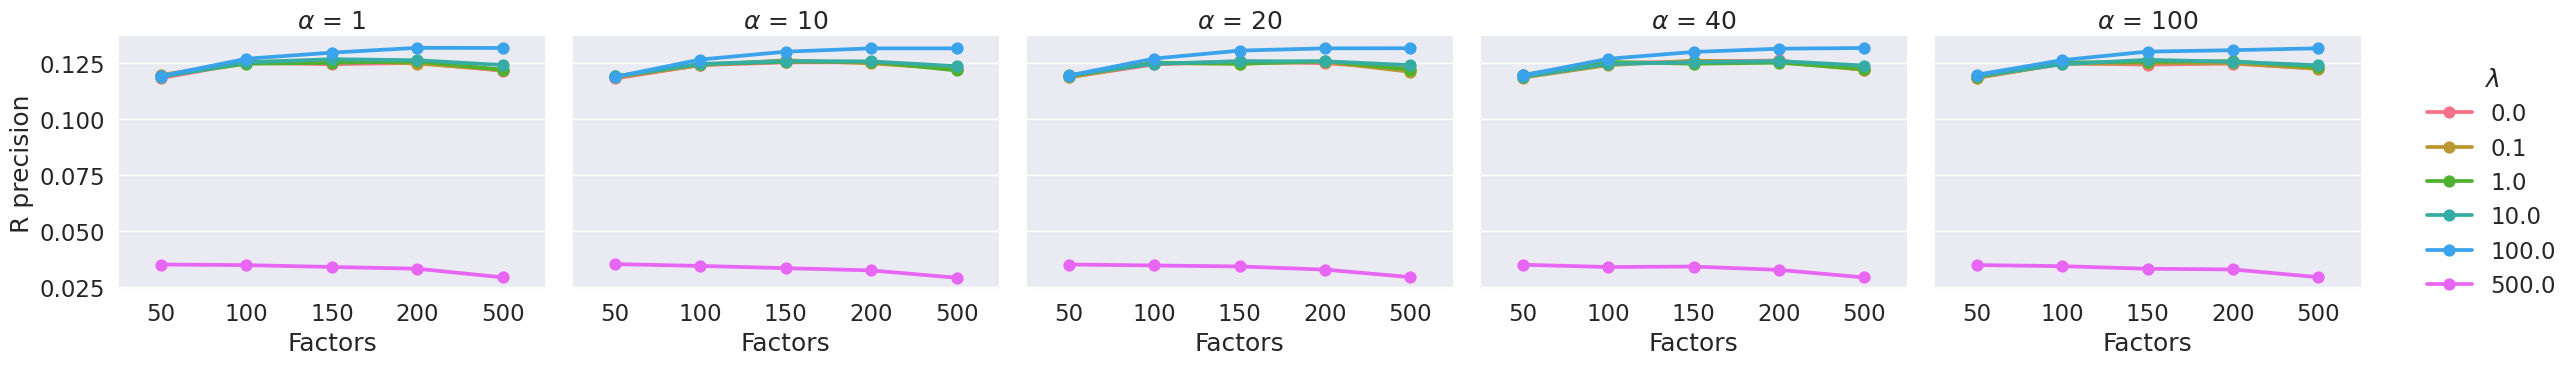

In [62]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

plt.figure(figsize=(10, 10))
g = sns.catplot(
    data=results_als_df, y="r_precision", x = "factors", col="alpha", hue="regularization", palette=sns.color_palette("husl", 6),
    kind="point", height=4, aspect=1.2, errorbar=None,
)

g.set_xlabels('Factors')
g.set_titles(r'$\alpha$ = {col_name}')
g._legend.set_title(title = r'$\lambda$')
g.set_ylabels('R precision');

## K-Nearest Neighbor for Collaborative Filtering

In [19]:
# create sparse training matrices
train_sparse_matrix = csr_matrix((train_df['val'].values.T, train_df[['playlist_id', 'track_id']].values.T), shape = (num_train_playlists, num_tracks))
train_sparse_matrix = train_sparse_matrix.T
train_sparse_matrix_normalized = csr_matrix((train_df['val_normalized'].values.T, train_df[['playlist_id', 'track_id']].values.T), shape = (num_train_playlists, num_tracks))

In [20]:
# for each playlist_id, get 500 track recommendations (that are not already in the dataset)
def get_recommendations_knn(pids, train_matrix, test_df, rho = 0.3, knn_K = 1000):
    recommendations = []
    for i, pid in enumerate(pids):
        # form the playlist vector
        playlist_tracks = test_df[(test_df.playlist_id == pid)]
        playlist_vec = np.zeros([num_tracks, 1])
        playlist_vec[playlist_tracks.track_id.values] = playlist_tracks[['val_normalized']].values / ((playlist_tracks[['popularity']].values - 1)**(rho) + 1)

        # get the similarities between playlist pid and every other playlist
        similarities = train_matrix.dot(playlist_vec)

        # get knn_K most similar playlists
        k_similar_playlists = similarities.reshape(-1).argsort()[-knn_K:][::-1]
        
        # get the similarity values
        similarity_values = similarities[k_similar_playlists]

        # get the predicted relevance of each song for the particular playlist
        predicted_relevance = train_matrix[k_similar_playlists, :].T.dot(similarity_values)

        # get the top 500 tracks that are not already in the playlist
        predicted_relevant_song_ids = predicted_relevance.reshape(-1).argsort()[-(500  + 25):][::-1]
        predicted_relevant_song_ids = predicted_relevant_song_ids[np.isin(predicted_relevant_song_ids, playlist_tracks.track_id) == False][:500]

        # append the recommendations to a dataframe
        recommendations.append(pd.DataFrame(
            {'playlist_id': np.repeat(pid, 500),
             'track_id': predicted_relevant_song_ids}
        ))

    # return the recommendations
    rcmds = pd.concat(recommendations, axis = 0)
    return rcmds

In [21]:
# compute r_precision
def r_prec(pids, df, groundtruth, recs):
    r_precision = 0
    for pid in pids:
        # get the ids of the songs that we know exist
        known_songs_ids = df[(df.playlist_id == pid)].track_id
        predicted_relevant_songs_ids = recs[recs['playlist_id'] == pid].track_id
        groundtruth_ids = groundtruth[groundtruth.playlist_id == pid].track_id

        hidden_relevant_song_ids = set(groundtruth_ids) - set(known_songs_ids)
        num_playlist_tracks = len(groundtruth[groundtruth['playlist_id'] == pid]['track_id'])
        num_hidden_tracks = num_playlist_tracks - 25
        top_k_predicted_relevant_songs = set(predicted_relevant_songs_ids[:num_hidden_tracks])
        r_precision += len(top_k_predicted_relevant_songs & hidden_relevant_song_ids) / num_hidden_tracks

    return r_precision

#### Hyperparameter tuning (training)

In [22]:
import multiprocessing
from functools import partial

NUM_THREADS = 32

ids = val_df['playlist_id'].unique()

knn_k = [100, 500, 1000, 2000]
rho = [0, 0.1, 0.3, 1.0]

best_r_precision_knn = -np.Inf
best_params_knn = {}

results = {}
results['knn_k'] = []
results['rho'] = []
results['r_precision'] = []

pool = multiprocessing.Pool(processes = NUM_THREADS)

for k in knn_k:
    for r in rho:
        print(f'Training for knn_K = {k} and rho = {r}')
        func = partial(get_recommendations_knn, train_matrix = train_sparse_matrix_normalized, test_df = val_df, rho = r, knn_K = k)
        recs_cf = list(pool.map(func, np.array_split(ids, NUM_THREADS)))
        recs_cf = pd.concat([r for r in recs_cf], axis = 0);

        func = partial(r_prec, df = val_df, groundtruth = groundtruth, recs = recs_cf)
        r_precision = sum(list(pool.map(func, np.array_split(ids, NUM_THREADS)))) / len(ids)
        print(f'R_precision for knn_K = {k} and rho = {r}: {r_precision}')

        if r_precision > best_r_precision_knn:
            best_r_precision_knn = r_precision
            best_params_knn['knn_k'] = k
            best_params_knn['rho'] = r

        results['knn_k'].append(k)
        results['rho'].append(r)
        results['r_precision'].append(r_precision)

pool.close()


Training for knn_K = 100 and rho = 0
R_precision for knn_K = 100 and rho = 0: 0.1565680427598487
Training for knn_K = 100 and rho = 0.1
R_precision for knn_K = 100 and rho = 0.1: 0.15913320436534797
Training for knn_K = 100 and rho = 0.3
R_precision for knn_K = 100 and rho = 0.3: 0.16348909672961823
Training for knn_K = 100 and rho = 1.0
R_precision for knn_K = 100 and rho = 1.0: 0.12553711253910985
Training for knn_K = 500 and rho = 0
R_precision for knn_K = 500 and rho = 0: 0.15958189761913405
Training for knn_K = 500 and rho = 0.1
R_precision for knn_K = 500 and rho = 0.1: 0.1638234939579543
Training for knn_K = 500 and rho = 0.3
R_precision for knn_K = 500 and rho = 0.3: 0.17065032917363812
Training for knn_K = 500 and rho = 1.0
R_precision for knn_K = 500 and rho = 1.0: 0.15351039494554508
Training for knn_K = 1000 and rho = 0
R_precision for knn_K = 1000 and rho = 0: 0.1590435338807164
Training for knn_K = 1000 and rho = 0.1
R_precision for knn_K = 1000 and rho = 0.1: 0.161511537

In [25]:
results_knn = results
results_knn_df = pd.DataFrame(results_knn)
results_knn_df.head()

,knn_k,rho,r_precision
0,100,0.0,0.156568
1,100,0.1,0.159133
2,100,0.3,0.163489
3,100,1.0,0.125537
4,500,0.0,0.159582


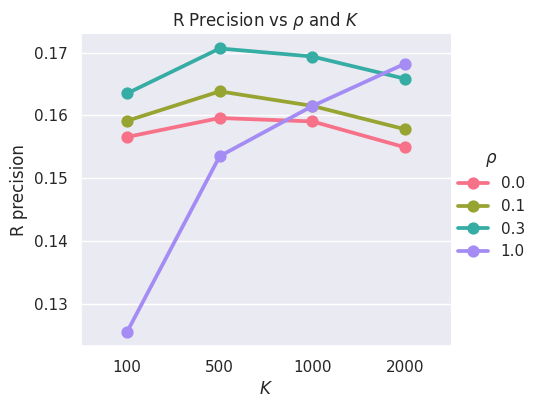

In [69]:
import matplotlib.pyplot as plt
sns.set(font_scale=1)

g = sns.catplot(
    data=results_knn_df, y="r_precision", x = "knn_k", hue="rho", palette=sns.color_palette("husl", 4),
    kind="point", height=4, aspect=1.2, errorbar=None,
)

g._legend.set_title(title = r'$\rho$')
g.set_xlabels(r'$K$')
g.set_ylabels('R precision');
plt.title(r'R Precision vs $\rho$ and $K$');

#### Evaluation on the testing dataset

In [27]:
ids = test_df['playlist_id'].unique()

pool = multiprocessing.Pool(processes = NUM_THREADS)
func = partial(get_recommendations_knn, train_matrix = train_sparse_matrix_normalized, test_df = test_df, rho = best_params_knn['rho'], knn_K = best_params_knn['knn_k'])
recs_cf = list(pool.map(func, np.array_split(ids, NUM_THREADS)))
recs_cf = pd.concat([r for r in recs_cf], axis = 0);

func = partial(r_prec, df = test_df, groundtruth = groundtruth, recs = recs_cf)
r_precision = sum(list(pool.map(func, np.array_split(ids, NUM_THREADS)))) / len(ids)
pool.close()
print('R_precision on testing set for knn_K = {} and rho = {}: {}'.format(best_params_knn['knn_k'], best_params_knn['rho'], r_precision))

R_precision on testing set for knn_K = 500 and rho = 0.3: 0.16304109859204638


## Hybrid recommendations: Collaborative + Content Based Filtering

In [28]:
# Construct a profile for each playlist
tracks.drop(columns = ['track_uri', 'track_name', 'artist_id', 'album_uri', 'duration_ms', 'album_name'], inplace=True)
tracks.fillna(value = 0.0, inplace=True)
tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,mode,loudness,speechiness,tempo,time_signature,valence
0,0,0.5680,0.458,0.591,0.000015,1.0,-5.621,0.0326,184.913,3.0,0.654
1,1,0.7970,0.455,0.623,0.903000,1.0,-11.572,0.0523,182.345,4.0,0.951
2,2,0.0178,0.742,0.753,0.000000,1.0,-5.632,0.0364,132.064,4.0,0.263
3,3,0.0860,0.733,0.711,0.000000,1.0,-5.408,0.1580,138.076,4.0,0.346
4,4,0.0145,0.584,0.947,0.000039,1.0,-3.702,0.0748,100.874,4.0,0.460


In [29]:
# exclude track id columns
cols = tracks.columns[tracks.columns != 'track_id']

# scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tracks[cols])
tracks[cols] = features_scaled

In [30]:
tracks.head(n = 10)

,track_id,acousticness,danceability,energy,instrumentalness,mode,loudness,speechiness,tempo,time_signature,valence
0,0,0.601704,-0.500671,0.023118,-0.631930,0.725836,0.717893,-0.491544,2.169227,-1.860936,0.660453
1,1,1.247874,-0.516925,0.143401,1.952452,0.725836,-0.339814,-0.320548,2.083432,0.254379,1.760497
2,2,-0.950795,1.038104,0.632050,-0.631974,0.725836,0.715938,-0.458560,0.403583,0.254379,-0.787753
3,3,-0.758355,0.989340,0.474179,-0.631974,0.725836,0.755751,0.596927,0.604439,0.254379,-0.480333
4,4,-0.960106,0.182025,1.361265,-0.631863,0.725836,1.058969,-0.125248,-0.638451,0.254379,-0.058094
5,5,1.253517,-0.235178,-0.521914,-0.631974,-1.377722,0.625470,-0.534943,0.440133,0.254379,-0.213656
6,6,1.490540,-1.611406,-1.457866,-0.615889,0.725836,-1.428092,-0.374364,-1.952034,0.254379,-0.365514
7,7,1.242230,-1.383840,-0.326455,2.069796,-1.377722,0.083553,-0.513244,-1.033548,-1.860936,-1.597044
8,8,-0.538262,0.528791,0.049430,-0.631842,0.725836,-0.388336,2.055164,0.631401,0.254379,-0.280325
9,9,-1.001001,0.783448,0.913963,1.803626,0.725836,0.505143,-0.377836,0.201457,0.254379,-1.624082


In [31]:
# compute the profile of each playlist
groundtruth_features = pd.merge(groundtruth, tracks, how = 'left', on = 'track_id')
groundtruth_features.head(n = 10)

,playlist_id,track_id,artist_id,pos,val,val_normalized,popularity,acousticness,danceability,energy,instrumentalness,mode,loudness,speechiness,tempo,time_signature,valence
0,0,476,254,7,1.0,0.138675,6293,-0.847803,1.081450,0.838786,-0.631345,-1.377722,1.355788,-0.045392,0.674064,0.254379,-0.787753
1,0,370,109,24,1.0,0.138675,5043,-0.998002,1.444471,-0.612127,1.903797,-1.377722,-0.422284,-0.242428,0.000668,0.254379,-1.191473
2,0,961,295,25,1.0,0.138675,8147,-0.442324,-0.050958,0.327584,-0.631974,0.725836,0.836088,0.206327,0.002572,2.369695,-1.221103
3,0,1831,838,26,1.0,0.138675,5704,-0.998637,-0.782418,1.391336,-0.234150,-1.377722,0.305723,-0.254580,0.818292,0.254379,-0.324772
4,0,454,276,27,1.0,0.138675,8822,-0.921449,0.555882,1.233465,-0.631970,-1.377722,1.225507,0.093488,0.267641,0.254379,0.012279
5,0,1816,836,28,1.0,0.138675,12380,-0.504402,1.216905,0.417796,-0.627080,0.725836,0.533936,-0.479392,-0.659498,0.254379,1.741977
6,0,376,210,29,1.0,0.138675,9763,-0.999133,0.100752,1.552966,1.594696,0.725836,1.178763,0.060504,-0.166278,0.254379,-1.017392
7,0,465,282,30,1.0,0.138675,20590,-0.944869,1.195232,0.782404,-0.621957,0.725836,-0.970066,-0.392592,0.214053,0.254379,1.838278
8,0,9815,3424,31,1.0,0.138675,5546,-1.000910,-0.787836,1.477789,-0.631920,0.725836,1.241681,-0.200764,-0.513266,0.254379,0.382664
9,0,395,257,32,1.0,0.138675,12997,0.533984,0.198280,-0.484326,-0.605615,0.725836,0.492346,-0.360476,0.731929,0.254379,-0.135875


In [32]:
groundtruth_features.drop(columns=['track_id', 'artist_id', 'pos', 'val', 'val_normalized', 'popularity'], inplace=True)

# compute the mean of each feature
playlist_profiles = groundtruth_features[groundtruth_features['playlist_id'].isin(train_ids)].groupby('playlist_id').mean() 
playlist_profiles.head()

,acousticness,danceability,energy,instrumentalness,mode,loudness,speechiness,tempo,time_signature,valence
playlist_id,,,,,,,,,,
0,0.003124,-0.169951,0.133396,-0.105709,-0.123678,0.114633,0.038019,-0.035124,0.091663,-0.176133
1,-0.171023,-0.302975,0.302650,-0.010814,-0.083225,0.098173,-0.054250,0.249510,-0.125293,-0.000874
2,-0.000776,0.218260,0.036556,-0.023574,-0.062999,0.039819,0.169912,-0.180629,-0.010035,0.105448
3,-0.041617,-0.130331,0.087979,0.001746,-0.042130,0.041428,-0.129285,0.050481,0.052921,0.078978
4,-0.309401,-0.315654,0.080805,0.186647,-0.387813,-0.240387,-0.066633,-0.047720,0.005519,0.007856


In [33]:
# normalize each entry by its norm-2
playlist_profiles = playlist_profiles.div(np.linalg.norm(playlist_profiles, axis = 1), axis = 0)
playlist_profiles.head()

,acousticness,danceability,energy,instrumentalness,mode,loudness,speechiness,tempo,time_signature,valence
playlist_id,,,,,,,,,,
0,0.008719,-0.474281,0.372269,-0.295001,-0.345148,0.319906,0.106100,-0.098020,0.255802,-0.491534
1,-0.307058,-0.543967,0.543384,-0.019415,-0.149424,0.176262,-0.097402,0.447975,-0.224953,-0.001570
2,-0.002171,0.610528,0.102255,-0.065942,-0.176223,0.111384,0.475288,-0.505266,-0.028071,0.294966
3,-0.172430,-0.539990,0.364515,0.007233,-0.174554,0.171646,-0.535657,0.209155,0.219262,0.327222
4,-0.460345,-0.469649,0.120226,0.277705,-0.577011,-0.357662,-0.099140,-0.071001,0.008211,0.011689


In [34]:
# for each playlist_id, get 500 track recommendations (that are not already in the dataset)
def get_recommendations_hybrid(pids, playlist_profiles, train_matrix, test_df, rho, knn_K, w1, w2):
    recommendations = []
    for i, pid in enumerate(pids):
        # form the playlist vector
        playlist_tracks = test_df[(test_df.playlist_id == pid)]
        playlist_vec = np.zeros([num_tracks, 1])
        playlist_vec[playlist_tracks.track_id.values] = playlist_tracks[['val_normalized']].values / ((playlist_tracks[['popularity']].values - 1)**(rho) + 1)

        # compute the playlist profile and normalize
        tracks_ids = test_df[test_df['playlist_id'] == pid].track_id.values
        playlist_profile = tracks[tracks['track_id'].isin(tracks_ids)].drop(columns='track_id').mean()
        playlist_profile = playlist_profile / np.linalg.norm(playlist_profile)

        # get the similarities between playlist pid and every other playlist
        similarities = w1 * train_matrix.dot(playlist_vec) + w2 * playlist_profiles.dot(playlist_profile).to_numpy().reshape(-1, 1)

        # get knn_K most similar playlists
        k_similar_playlists = similarities.reshape(-1).argsort()[-knn_K:][::-1]
        
        # get the similarity values
        similarity_values = similarities[k_similar_playlists]
        
        # get the predicted relevance of each song for the particular playlist
        predicted_relevance = train_matrix[k_similar_playlists, :].T.dot(similarity_values)

        # get the top 500 tracks that are not already in the playlist
        predicted_relevant_song_ids = predicted_relevance.reshape(-1).argsort()[-(500  + 25):][::-1]
        predicted_relevant_song_ids = predicted_relevant_song_ids[np.isin(predicted_relevant_song_ids, playlist_tracks.track_id) == False][:500]

        # append the recommendations to a dataframe
        recommendations.append(pd.DataFrame(
            {'playlist_id': np.repeat(pid, 500),
             'track_id': predicted_relevant_song_ids}
        ))

    # return the recommendations
    rcmds = pd.concat(recommendations, axis = 0)
    return rcmds

#### Hyperparameter tuning (training)

In [36]:
import multiprocessing
from functools import partial

NUM_THREADS = 32

ids = val_df['playlist_id'].unique()

best_params_knn = {}
best_params_knn['knn_k'] = 500
best_params_knn['rho'] = 0.3

best_w1 = None
best_w2 = None
best_r_precision_hybrid = -np.Inf
w1 = [0.0, 1.0]
w2 = [0.0, 0.5, 1.0, 2.0]

results = {}
results['w1'] = []
results['w2'] = []
results['r_precision'] = []

pool = multiprocessing.Pool(processes = NUM_THREADS)

for weight1 in w1:
    for weight2 in w2:
        if weight1 == 0 and weight2 != 1.0:
            continue

        func = partial(get_recommendations_hybrid, playlist_profiles = playlist_profiles, train_matrix = train_sparse_matrix_normalized, 
                    test_df = val_df, rho = best_params_knn['rho'], knn_K = best_params_knn['knn_k'], w1 = weight1, w2 = weight2)
        recs_hybrid = list(pool.map(func, np.array_split(ids, NUM_THREADS)))
        recs_hybrid = pd.concat([r for r in recs_hybrid], axis = 0);
        func = partial(r_prec, df = val_df, groundtruth = groundtruth, recs = recs_hybrid)
        r_precision = sum(list(pool.map(func, np.array_split(ids, NUM_THREADS)))) / len(ids)
        
        print('R_precision for knn_K = {}, rho = {}, w1 = {}, w2 = {}: {}'.format(best_params_knn['knn_k'], best_params_knn['rho'], weight1, weight2, r_precision))

        if r_precision > best_r_precision_hybrid:
            best_w1 = weight1
            best_w2 = weight2
            best_r_precision_hybrid = r_precision

        results['w1'].append(weight1)
        results['w2'].append(weight2)
        results['r_precision'].append(r_precision)

pool.close()

R_precision for knn_K = 500, rho = 0.3, w1 = 0.0, w2 = 1.0: 0.021449264681776718
R_precision for knn_K = 500, rho = 0.3, w1 = 1.0, w2 = 0.0: 0.17065032917363812
R_precision for knn_K = 500, rho = 0.3, w1 = 1.0, w2 = 0.5: 0.025522869836119667
R_precision for knn_K = 500, rho = 0.3, w1 = 1.0, w2 = 1.0: 0.02295708978558107
R_precision for knn_K = 500, rho = 0.3, w1 = 1.0, w2 = 2.0: 0.02234637595900555


#### Evaluation on the testing dataset

In [37]:
ids = test_df['playlist_id'].unique()

pool = multiprocessing.Pool(processes = NUM_THREADS)
func = partial(get_recommendations_hybrid, playlist_profiles = playlist_profiles, train_matrix = train_sparse_matrix_normalized, test_df = test_df, 
               rho = best_params_knn['rho'], knn_K = best_params_knn['knn_k'], w1 = best_w1, w2 = best_w2)
recs_hybrid = list(pool.map(func, np.array_split(ids, NUM_THREADS)))
recs_hybrid = pd.concat([r for r in recs_hybrid], axis = 0);

func = partial(r_prec, df = test_df, groundtruth = groundtruth, recs = recs_hybrid)
r_precision = sum(list(pool.map(func, np.array_split(ids, NUM_THREADS)))) / len(ids)
pool.close()
print('R_precision on testing set for knn_K = {}, rho = {}, w1 = {}, w2 = {}: {}'.format(best_params_knn['knn_k'], best_params_knn['rho'], best_w1, best_w2, r_precision))

R_precision on testing set for knn_K = 500, rho = 0.3, w1 = 1.0, w2 = 0.0: 0.16304109859204638


In [39]:
results_hybrid = results
results_hybrid_df = pd.DataFrame(results_hybrid)
results_hybrid_df.head()

,w1,w2,r_precision
0,0.0,1.0,0.021449
1,1.0,0.0,0.170650
2,1.0,0.5,0.025523
3,1.0,1.0,0.022957
4,1.0,2.0,0.022346


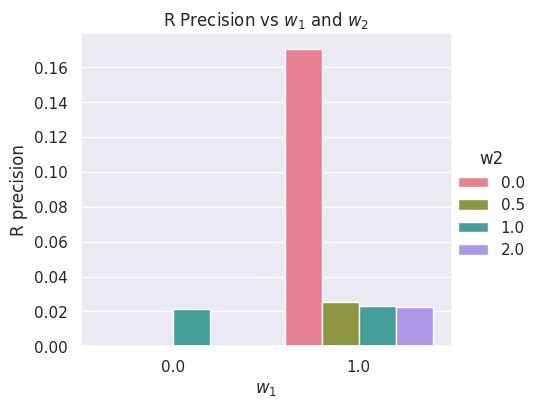

In [71]:
import matplotlib.pyplot as plt

g = sns.catplot(
    data=results_hybrid_df, y="r_precision", hue="w2", x = "w1", palette=sns.color_palette("husl", 4),
    kind="bar", height=4, aspect=1.2, errorbar=None,
)

g.set_xlabels(r'$w_1$')
g._legend.set_title(r'$w_2$')
g.set_ylabels('R precision');
plt.title(r'R Precision vs $w_1$ and $w_2$');